### Imports

In [1]:
from IPython.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import glob
import json
import os
import pickle
import random
import sys
from copy import deepcopy
from typing import Literal, Optional, Union
from pathlib import Path
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import ml_collections
import numpy as np
import torch
from torch.utils.data import Dataset

from careamics.config.likelihood_model import NMLikelihoodConfig
from careamics.config.nm_model import MultiChannelNMConfig
from careamics.config import VAEAlgorithmConfig
from careamics.lightning import VAEModule
from careamics.lvae_training.eval_utils import (
    Calibration,
    get_calibrated_factor_for_stdev,
    get_dset_predictions,
    get_eval_output_dir,
    plot_calibration,
    plot_error,
    show_for_one,
    stitch_predictions,
)
from careamics.config.architectures import LVAEModel
from careamics.config.nm_model import GaussianMixtureNMConfig, MultiChannelNMConfig
from careamics.config.likelihood_model import (
    GaussianLikelihoodConfig,
    NMLikelihoodConfig,
)
from careamics.config.loss_model import LVAELossConfig, KLLossConfig

from careamics.lvae_training.eval_utils import stitch_predictions_new
from careamics.config.optimizer_models import LrSchedulerModel, OptimizerModel
from careamics.models.lvae.noise_models import noise_model_factory
from careamics.utils.metrics import (
    # avg_psnr,
    # avg_range_inv_psnr,
    # avg_ssim,
    scale_invariant_psnr,
    # multiscale_ssim
)
# TODO: sorry for this :(
sys.path.insert(0, "/home/federico.carrara/Documents/projects/microSplit-reproducibility/")
sys.path.insert(0, "/home/igor.zubarev/projects/microSplit-reproducibility/")

from data import (
    LCMultiChDloader, MultiChDloader, DataSplitType, DataType
)
from data.data_utils import GridAlignement, load_tiff

from datasets import load_train_val_dao_3ch, create_train_val_datasets
from configs.data.dao3ch import get_data_configs

torch.multiprocessing.set_sharing_strategy('file_system')

In [5]:
def fix_seeds():
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.deterministic = True

fix_seeds()

In [6]:
DATA_DIR = "/localscratch/data/Dao3Channel/"
OUT_ROOT = '/home/igor.zubarev/data/splits/'
DEBUG = False

In [7]:
ckpt_dir = os.path.join(OUT_ROOT, '2411/denoisplit_with_LC/7')
assert os.path.exists(ckpt_dir)

### Set Evaluation Parameters

In [8]:
# --- Custom parameters # TODO move to a separate file
img_size: int = [64, 64]
"""Spatial size of the input image."""
target_channels: int = 2
"""Number of channels in the target image."""
multiscale_count: int = 3
"""The number of LC inputs plus one (the actual input)."""
predict_logvar: Optional[Literal["pixelwise"]] = "pixelwise"
"""Whether to compute also the log-variance as LVAE output."""
loss_type: Optional[Literal["musplit", "denoisplit", "denoisplit_musplit"]] = "denoisplit_musplit"

In [43]:
# Set eval parameters
mmse_count: int = 10
"""The number of predictions to average for MMSE evaluation."""
image_size_for_grid_centers: int = 32
"""The size of the portion of image we retain from inner padding/tiling."""
eval_patch_size: Optional[int] = 64
"""The actual patch size. If not specified data.image_size."""
psnr_type: Literal['simple', 'range_invariant'] = 'range_invariant'
"""The type of PSNR to compute."""
which_ckpt: Literal['best', 'last'] = 'best'
"""Which checkpoint to use for evaluation."""
enable_calibration: bool = False
"""Whether to enable calibration."""
eval_datasplit_type = DataSplitType.Test
"""The data split used for evaluation."""
batch_size: int = 32
"""Batch size for data loader."""
num_workers = 4
"""Number of workers for data loader."""
use_deterministic_grid = None
"""Whether to use a deterministic grid for evaluation (i.e., get a random patch)."""
data_t_list = None
"""List of indexes of the data to be used (e.g., for debugging or picking a particular image)."""

'List of indexes of the data to be used (e.g., for debugging or picking a particular image).'

### Load config 

In [10]:
# TODO move to a separate file
def get_model_checkpoint(
    ckpt_dir: str, mode: Literal['best', 'last'] = 'best'
) -> str:
    output = []
    for fpath in glob.glob(ckpt_dir + "/*.ckpt"):
        fname = os.path.basename(fpath)
        if mode == 'best':
            if fname.startswith('best'):
                output.append(fpath)
        elif mode == 'last':
            if fname.startswith('last'):
                output.append(fpath)
    assert len(output) == 1, '\n'.join(output)
    return output[0]

In [11]:
# TODO move to a separate file

def load_file(file_path: str):
    # Get the file extension
    _, ext = os.path.splitext(file_path)

    # Check the extension and load the file accordingly
    if ext == '.pkl':
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    elif ext == '.json':
        with open(file_path) as f:
            return json.load(f)
    else:
        raise ValueError(f"Unsupported file extension: {ext}. Only .pkl and .json are supported.")

def load_config(config_fpath: str, config_type: Literal['algorithm', 'training', 'data']) -> dict:
    for fname in glob.glob(os.path.join(config_fpath, '*config.*')):
        fname = os.path.basename(fname)
        if fname.startswith(config_type):
            return load_file(os.path.join(config_fpath, fname))
    raise ValueError(f"Config file not found in {config_fpath}.")

In [12]:
if os.path.isdir(ckpt_dir):
    algo_config = load_config(ckpt_dir, "algorithm")
    training_config = load_config(ckpt_dir, "training")
    data_config = load_config(ckpt_dir, "data")

### Load dataset

In [13]:
train_data_config, val_data_config, test_data_config = get_data_configs()
# training_config = TrainingConfig()
train_data_config.channel_idx_list = [0, 1]
val_data_config.channel_idx_list = [0, 1]
test_data_config.channel_idx_list = [0, 1]
train_dset, val_dset, test_dset, data_stats = create_train_val_datasets(
    datapath=DATA_DIR,
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=test_data_config,
    load_data_func=load_train_val_dao_3ch
)


Selecting channels [0, 1]
Loaded from SubDsetType.MultiChannel /localscratch/data/Dao3Channel/ 90/112 frames

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with 

Actual dataset

In [14]:
# Set some params
# TODO: check if this is right
if eval_patch_size is not None:
    training_image_size = data_config["image_size"]
    data_config["image_size"] = eval_patch_size

if image_size_for_grid_centers is not None:
    training_grid_size = data_config.get("grid_size", "grid_size not present")
    data_config["grid_size"] = image_size_for_grid_centers

padding_kwargs = {"mode": "reflect"}
dset_kwargs = {
    "overlapping_padding_kwargs": padding_kwargs,
    "grid_alignment": GridAlignement.Center
}

In [15]:
data_config


{'data_type': 7,
 'depth3D': 1,
 'datasplit_type': 1,
 'num_channels': 2,
 'ch1_fname': None,
 'ch2_fname': None,
 'ch_input_fname': None,
 'input_is_sum': False,
 'input_idx': None,
 'target_idx_list': None,
 'start_alpha': None,
 'end_alpha': None,
 'image_size': 64,
 'grid_size': 32,
 'empty_patch_replacement_enabled': False,
 'empty_patch_replacement_channel_idx': None,
 'empty_patch_replacement_probab': None,
 'empty_patch_max_val_threshold': None,
 'uncorrelated_channels': False,
 'uncorrelated_channel_probab': 0.5,
 'poisson_noise_factor': -1.0,
 'synthetic_gaussian_scale': 6675.0,
 'input_has_dependant_noise': True,
 'enable_gaussian_noise': False,
 'allow_generation': False,
 'training_validtarget_fraction': None,
 'deterministic_grid': None,
 'enable_rotation_aug': False,
 'max_val': None,
 'overlapping_padding_kwargs': {'mode': 'reflect'},
 'print_vars': False,
 'normalized_input': True,
 'use_one_mu_std': True,
 'train_aug_rotate': True,
 'enable_random_cropping': True,
 'm

Noise-free dataset (High-SNR)

In [16]:
training_config

{'batch_size': 64,
 'precision': '16-mixed',
 'lr': 0.001,
 'lr_scheduler_patience': 7,
 'earlystop_patience': 50,
 'max_epochs': 100,
 'num_workers': 4,
 'grad_clip_norm_value': 0.5,
 'gradient_clip_algorithm': 'value',
 'limit_train_batches': 1000}

In [17]:
for i in train_data_config:
    print(i)
    

('data_type', <DataType.Dao3Channel: 7>)
('depth3D', 1)
('datasplit_type', <DataSplitType.Train: 1>)
('num_channels', 2)
('ch1_fname', None)
('ch2_fname', None)
('ch_input_fname', None)
('input_is_sum', False)
('input_idx', None)
('target_idx_list', None)
('start_alpha', None)
('end_alpha', None)
('image_size', (64, 64))
('grid_size', 32)
('empty_patch_replacement_enabled', False)
('empty_patch_replacement_channel_idx', None)
('empty_patch_replacement_probab', None)
('empty_patch_max_val_threshold', None)
('uncorrelated_channels', False)
('uncorrelated_channel_probab', 0.5)
('poisson_noise_factor', -1.0)
('synthetic_gaussian_scale', 6675.0)
('input_has_dependant_noise', True)
('enable_gaussian_noise', False)
('allow_generation', False)
('training_validtarget_fraction', None)
('deterministic_grid', None)
('enable_rotation_aug', False)
('max_val', None)
('overlapping_padding_kwargs', {'mode': 'reflect'})
('print_vars', False)
('normalized_input', True)
('use_one_mu_std', True)
('train_au

### Create model

Note: noise model and the associated likelihood are not saved in the config, hence we need to reinitialize them.

In [18]:
nm_paths: Optional[tuple[str]] = [
    "/group/jug/ashesh/training/noise_model/2405/4/GMMNoiseModel_Dao3Channel-SIM1__6_4_Clip0.0-1.0_Sig0.125_UpNone_Norm0_bootstrap.npz",
    "/group/jug/ashesh/training/noise_model/2405/5/GMMNoiseModel_Dao3Channel-SIM1__6_4_Clip0.0-1.0_Sig0.125_UpNone_Norm0_bootstrap.npz",
]

In [19]:
def create_split_lightning_model(
    algorithm: str,
    loss: str,
    model_parameters: dict,
    data_config: dict,
    training_config = None,
) -> VAEModule:
    """Instantiate the muSplit lightining model."""
    lvae_config = LVAEModel(
        architecture="LVAE",
        input_shape=model_parameters["img_size"],
        multiscale_count=model_parameters["multiscale_count"],
        z_dims=[128, 128, 128, 128],
        output_channels=model_parameters["target_ch"],
        predict_logvar=model_parameters["predict_logvar"],
        analytical_kl=False,
    )

    # gaussian likelihood
    if loss in ["musplit", "denoisplit_musplit"]:
        gaussian_lik_config = GaussianLikelihoodConfig(
            predict_logvar=model_parameters["predict_logvar"],
            logvar_lowerbound=-5.0,  # TODO: find a better way to fix this
        )
    else:
        gaussian_lik_config = None
    # noise model likelihood
    if loss in ["denoisplit", "denoisplit_musplit"]:
        gmm_list = []
        for NM_path in model_parameters["nm_paths"]:
            gmm_list.append(
                GaussianMixtureNMConfig(
                    model_type="GaussianMixtureNoiseModel",
                    path=NM_path,
                )
            )
        noise_model_config = MultiChannelNMConfig(noise_models=gmm_list)
        nm_lik_config = NMLikelihoodConfig(
            data_mean=data_config["data_stats"][0],
            data_std=data_config["data_stats"][1],
        )
    else:
        noise_model_config = None
        nm_lik_config = None

    loss_config = LVAELossConfig(
        loss_type=loss,
        kl_params=KLLossConfig()
    )

    opt_config = OptimizerModel(
        name="Adamax",
        parameters={
            "lr": training_config["lr"],
            "weight_decay": 0,
        },
    )
    lr_scheduler_config = LrSchedulerModel(
        name="ReduceLROnPlateau",
        parameters={
            "mode": "min",
            "factor": 0.5,
            "patience": training_config["lr_scheduler_patience"],
            "verbose": True,
            "min_lr": 1e-12,
        },
    )

    vae_config = VAEAlgorithmConfig(
        algorithm_type="vae",
        algorithm=algorithm,
        loss=loss_config,
        model=lvae_config,
        gaussian_likelihood=gaussian_lik_config,
        noise_model=noise_model_config,
        noise_model_likelihood=nm_lik_config,
        optimizer=opt_config,
        lr_scheduler=lr_scheduler_config,
    )

    return VAEModule(algorithm_config=vae_config)


In [20]:
lightning_model = create_split_lightning_model(
        algorithm="denoisplit",
        loss="denoisplit_musplit",
        model_parameters={"img_size": img_size,
        "multiscale_count": multiscale_count,
        "predict_logvar": predict_logvar,
        "target_ch": target_channels,
        "nm_paths": nm_paths},
        data_config={"data_stats": data_stats},
        training_config=training_config,
    )

/home/igor.zubarev/projects/careamics/src/careamics/utils/serializers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(lst)


[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[MultiChannelNoiseModel] Nmodels count:2
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5.0


In [44]:
if os.path.isdir(ckpt_dir):
    ckpt_fpath = get_model_checkpoint(ckpt_dir, mode=which_ckpt)
else:
    assert os.path.isfile(ckpt_dir)
    ckpt_fpath = ckpt_dir

print(f"Loading checkpoint from: '{ckpt_fpath}'")

Loading checkpoint from: '/home/igor.zubarev/data/splits/2411/denoisplit_with_LC/7/best-epoch=7.ckpt'


In [22]:
checkpoint = torch.load(ckpt_fpath)

lightning_model.load_state_dict(checkpoint['state_dict'], strict=True)
lightning_model.eval()
lightning_model.cuda()

print('Loading weights from epoch', checkpoint['epoch'])

Loading weights from epoch 11


### From here on we perform evaluation

Visualize Data: noisy & ground truth

#### Compute predictions and related metrics (PSNR) for the entire validation set

In [23]:
test_dset.dsets = test_dset.dsets[:1] # otherwise it's too long and crashes cuz of memory leak! 

In [24]:
# NOTE: here, patch-wise PSNR is used, hence results are not trustworthy
pred_tiled = get_dset_predictions(
  model=lightning_model,
  dset=test_dset,
  batch_size=batch_size,
  num_workers=num_workers,
  mmse_count=mmse_count,
  loss_type=algo_config["loss"],
)

Predicting patches:   7%|▋         | 34/505 [00:44<08:45,  1.11s/it]

Predicting patches: 100%|██████████| 505/505 [09:25<00:00,  1.12s/it]


In [25]:
# tmp = np.round([x.item() for x in patch_psnr_tuple], 2)
# print(f"Patch wise PSNR, as computed during training {tmp}, avg: {np.mean(tmp)}")
print(f'Number of predicted tiles: {pred_tiled.shape[0]}, channels: {pred_tiled.shape[1]}, shape: {pred_tiled.shape[2:]}')
# print(f'Reconstruction loss distrib: {np.quantile(rec_loss, [0,0.01,0.5, 0.9,0.99,0.999,1]).round(2)}')

Number of predicted tiles: 16129, channels: 2, shape: (64, 64)


Get full image predictions by stitching the predicted tiles

In [26]:

# # Stitch predicted tiled logvar
# if len(np.unique(logvar_tiled)) == 1:
#     logvar = None
# else:
#     logvar = stitch_predictions(logvar_tiled, val_dset, smoothening_pixelcount=0) # TODO: there's a bug here

# Stitch the std of the predictions (i.e., std computed on the mmse_count predictions)
if pred_tiled.shape[-1] != test_dset.get_img_sz():
    pad = (val_dset.get_img_sz() - pred_tiled.shape[-1] )//2
    pred_tiled = np.pad(pred_tiled, ((0,0),(0,0),(pad,pad),(pad,pad)))


In [27]:
# Stitch tiled predictions
pred = stitch_predictions_new(
    pred_tiled,
    test_dset.dsets[0],
)

Ignore (and remove) the pixels which are present in the last few rows and columns (since not multiples of patch_size)
1. They don't come in the batches. So, in prediction, they are simply zeros. So they are being are ignored right now. 
2. For the border pixels which are on the top and the left, overlapping yields worse performance. This is becuase, there is nothing to overlap on one side. So, they are essentially zero padded. This makes the performance worse. 

In [28]:
pred.shape

(1, 4096, 4096, 2)

In [29]:
def get_ignored_pixels():
    """Get the number of ignored pixels in the predictions.
    
    Given the current predictions `pred`, analyze the first image std
    to find the number of pixels that are ignored in prediction.
    """
    ignored_pixels = 1
    while(pred[0, -ignored_pixels:, -ignored_pixels:,].std() == 0):
        ignored_pixels+=1
    ignored_pixels-=1
    print(f'In {pred.shape}, last {ignored_pixels} many rows and columns are all zero.')
    return ignored_pixels

actual_ignored_pixels = get_ignored_pixels()
print(f'Actual ignored pixels: {actual_ignored_pixels}')

In (1, 4096, 4096, 2), last 16 many rows and columns are all zero.
Actual ignored pixels: 16


In [30]:
if data_config["data_type"] in [
    DataType.OptiMEM100_014,
    DataType.SemiSupBloodVesselsEMBL,
    DataType.Pavia2VanillaSplitting,
    DataType.ExpansionMicroscopyMitoTub,
    DataType.ShroffMitoEr,
    DataType.HTIba1Ki67
]:
    ignored_last_pixels = 32
elif data_config["data_type"] == DataType.BioSR_MRC:
    ignored_last_pixels = 44
elif data_config["data_type"] == DataType.NicolaData:
    ignored_last_pixels = 8
else:
    ignored_last_pixels = 0

ignore_first_pixels = 0
# assert actual_ignored_pixels <= ignored_last_pixels, f'Set ignored_last_pixels={actual_ignored_pixels}' # TODO: check this once stitching is fixed
print(ignored_last_pixels)

0


In [31]:
tar = test_dset.dsets[0]._data
"""Data used to do evaluation againts. Shape is (N, H, W, C).

NOTE: this is the original data (`dset._data`), hence not normalized!
"""

if DEBUG:
    if 'target_idx_list' in data_config and data_config.target_idx_list is not None:
        tar = tar[..., data_config.target_idx_list]

def ignore_pixels(
    arr: Union[np.ndarray, torch.Tensor],
    patch_size: int
) -> Union[np.ndarray, torch.Tensor]:
    """Remove pixels that are ignored in the predictions."""
    if arr.shape[2] % patch_size:
        if ignore_first_pixels:
            arr = arr[:,ignore_first_pixels:,ignore_first_pixels:]
        if ignored_last_pixels:
            arr = arr[:,:-ignored_last_pixels,:-ignored_last_pixels]
    return arr

pred = ignore_pixels(pred, val_dset.get_img_sz())
tar = ignore_pixels(tar, val_dset.get_img_sz())
# if pred_std is not None:
#     pred_std = ignore_pixels(pred_std, val_dset.get_img_sz())

print(pred.shape)

(1, 4096, 4096, 2)


#### Perform Calibration

In [32]:
# TODO: move calibration to a separate file !


Plot RMV vs. RMSE without Calibration

Observe that the plot is far from resembling y = x!

#### Visually compare Targets and Predictions

In [33]:
data_mean = data_stats[0]
data_std = data_stats[1]

In [34]:
sep_mean = np.transpose(data_mean.numpy(), axes=(0, 2, 3, 1))
sep_std = np.transpose(data_std.numpy(), axes=(0, 2, 3, 1))

tar_normalized = (tar - sep_mean)/ sep_std

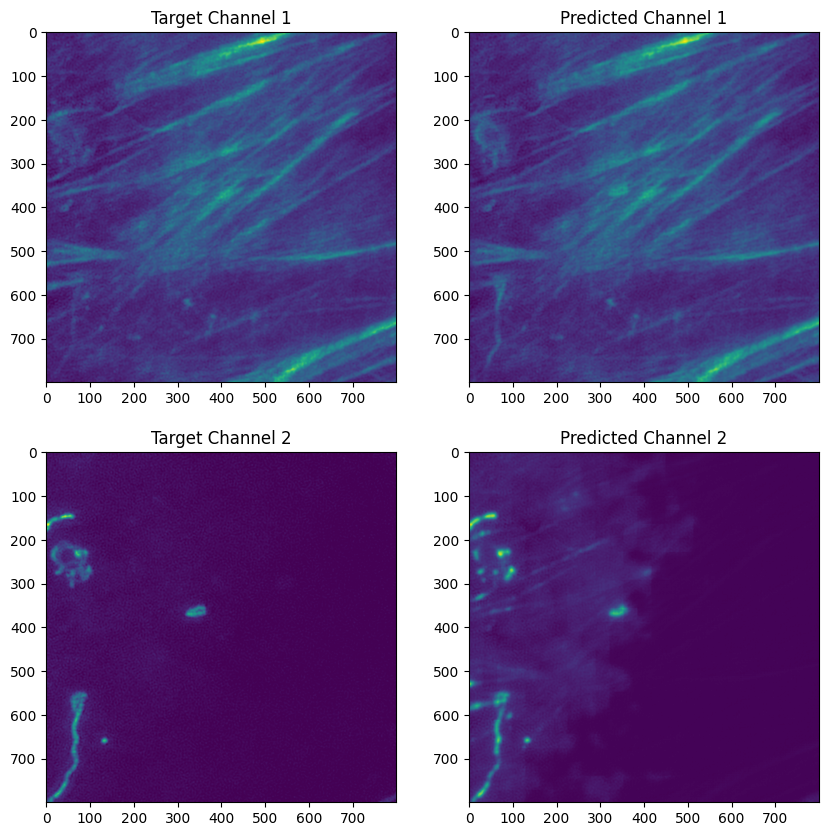

In [35]:
# One random target vs predicted image (patch of shape [sz x sz])
ncols = tar.shape[-1]
_,ax = plt.subplots(figsize=(ncols*5, 2*5), nrows=2, ncols=ncols)
img_idx = 10
sz = 800
hs = np.random.randint(tar.shape[1] - sz)
ws = np.random.randint(tar.shape[2] - sz)
for i in range(ncols):
    ax[i,0].set_title(f'Target Channel {i+1}')
    ax[i,0].imshow(tar[0, hs:hs+sz, ws:ws+sz, i])
    ax[i,1].set_title(f'Predicted Channel {i+1}')
    ax[i,1].imshow(pred[0, hs:hs+sz, ws:ws+sz, i])

# plt.subplots_adjust(wspace=0.1, hspace=0.1)
# clean_ax(ax)

0


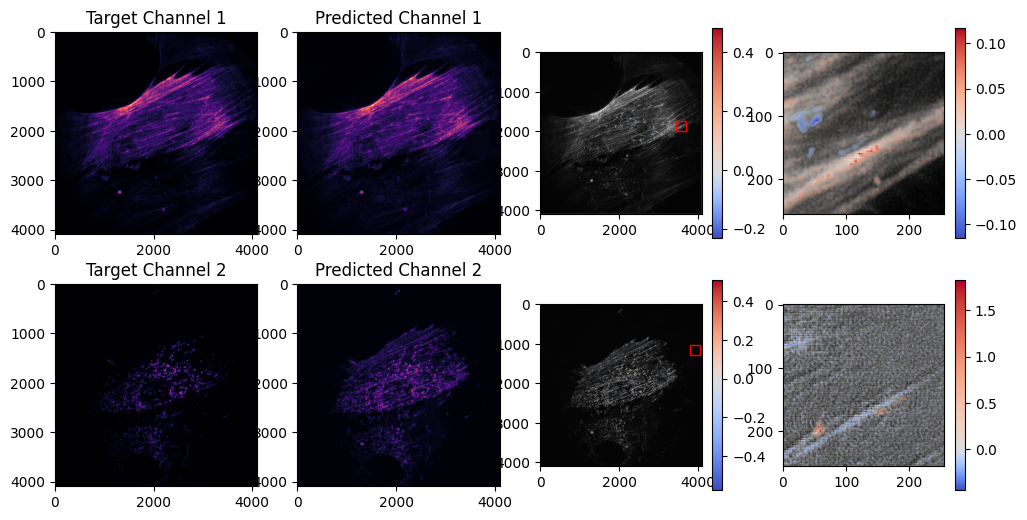

In [37]:
nrows = pred.shape[-1]
img_sz = 3
_,ax = plt.subplots(figsize=(4*img_sz,nrows*img_sz), ncols=4, nrows=nrows)
idx = np.random.randint(len(pred))
print(idx)
for ch_id in range(nrows):
    ax[ch_id,0].set_title(f'Target Channel {ch_id+1}')
    ax[ch_id,0].imshow(tar_normalized[idx,..., ch_id], cmap='magma')
    ax[ch_id,1].set_title(f'Predicted Channel {ch_id+1}')
    ax[ch_id,1].imshow(pred[idx,:,:,ch_id], cmap='magma')
    plot_error(
        tar_normalized[idx,...,ch_id],
        pred[idx,:,:,ch_id],
        cmap = matplotlib.cm.coolwarm,
        ax = ax[ch_id,2],
        max_val = None
    )

    cropsz = 256
    h_s = np.random.randint(0, tar_normalized.shape[1] - cropsz)
    h_e = h_s + cropsz
    w_s = np.random.randint(0, tar_normalized.shape[2] - cropsz)
    w_e = w_s + cropsz

    plot_error(
        tar_normalized[idx,h_s:h_e,w_s:w_e, ch_id],
        pred[idx,h_s:h_e,w_s:w_e,ch_id],
        cmap = matplotlib.cm.coolwarm,
        ax = ax[ch_id,3],
        max_val = None
    )

    # Add rectangle to the region
    rect = patches.Rectangle((w_s, h_s), w_e-w_s, h_e-h_s, linewidth=1, edgecolor='r', facecolor='none')
    ax[ch_id,2].add_patch(rect)


#### Compute metrics between predicted data and high-SNR (ground truth) data

Prepare data:

In [38]:
pred_unnorm = []
for i in range(pred.shape[-1]):
    if sep_std.shape[-1] == 1:
        temp_pred_unnorm = pred[...,i] * sep_std[...,0] + sep_mean[...,0]
    else:
        temp_pred_unnorm = pred[...,i] * sep_std[...,i] + sep_mean[...,i]
    pred_unnorm.append(temp_pred_unnorm)

Compute metrics:

In [39]:
def avg_range_inv_psnr(
    pred: np.ndarray,
    target: np.ndarray,
) -> float:
    """Compute the average range-invariant PSNR."""
    psnr_arr = []
    for i in range(pred.shape[0]):
        psnr_arr.append(scale_invariant_psnr(pred[i], target[i]))
    return np.mean(psnr_arr)

In [40]:
tar_normalized.min(), tar_normalized.max(), pred.min(), pred.max()

(-0.7553406, 41.322857, -1.05008, 28.202457)

In [41]:
rmse_arr = []
psnr_arr = []
rinv_psnr_arr = []
ssim_arr = []
for ch_id in range(pred.shape[-1]):
    rmse =np.sqrt(((pred[...,ch_id] - tar_normalized[...,ch_id])**2).reshape(len(pred),-1).mean(axis=1))
    rmse_arr.append(rmse)
    # psnr = avg_psnr(tar_normalized[...,ch_id].copy(), pred[...,ch_id].copy())
    rinv_psnr = avg_range_inv_psnr(tar_normalized[...,ch_id].copy(), pred[...,ch_id].copy())
    # ssim_mean, ssim_std = avg_ssim(tar[...,ch_id], pred_unnorm[ch_id])
    # psnr_arr.append(psnr)
    rinv_psnr_arr.append(rinv_psnr)
    # ssim_arr.append((ssim_mean,ssim_std))

In [42]:
print(f'{DataSplitType.name(eval_datasplit_type)}_P{eval_patch_size}_G{image_size_for_grid_centers}_M{mmse_count}_Sk{ignored_last_pixels}')
# print('Rec Loss: ', np.round(rec_loss.mean(),3) )
print('RMSE: ', ' <--> '.join([str(np.mean(x).round(3)) for x in rmse_arr]))
print('PSNR: ', ' <--> '.join([str(x) for x in psnr_arr]))
print('RangeInvPSNR: ',' <--> '.join([str(x) for x in rinv_psnr_arr]))
print('SSIM: ',' <--> '.join([f'{round(x,3)}±{round(y,4)}' for (x,y) in ssim_arr]))
print()

Test_P64_G32_M10_Sk0
RMSE:  0.3 <--> 1.097
PSNR:  
RangeInvPSNR:  38.49838536453326 <--> 32.56664953203128
SSIM:  

